In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed data
train_data = pd.read_csv('../data/processed/train_features.csv')
test_data = pd.read_csv('../data/processed/test_features.csv')

print(f"Train data loaded: {train_data.shape}")
print(f"Test data loaded: {test_data.shape}")
print(f"\nTarget distribution:")
print(train_data['reordered'].value_counts())
print(f"Positive class: {train_data['reordered'].mean()*100:.2f}%")

Train data loaded: (8474661, 17)
Test data loaded: (4833292, 16)

Target distribution:
reordered
0    7645837
1     828824
Name: count, dtype: int64
Positive class: 9.78%


In [2]:
# Separate features and target
feature_cols = [col for col in train_data.columns if col not in ['user_id', 'product_id', 'reordered']]

print(f"Feature columns ({len(feature_cols)}):")
print(feature_cols)
print("\n")

# Create X and y
X = train_data[feature_cols]
y = train_data['reordered']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nX first 5 rows:")
print(X.head())

Feature columns (14):
['user_total_orders', 'user_avg_days_between_orders', 'user_total_products', 'user_total_reorders', 'user_reorder_rate', 'user_avg_basket_size', 'product_total_purchases', 'product_total_reorders', 'product_unique_users', 'product_reorder_probability', 'up_order_count', 'up_reorder_count', 'up_reorder_rate', 'up_orders_since_last']


X shape: (8474661, 14)
y shape: (8474661,)

X first 5 rows:
   user_total_orders  user_avg_days_between_orders  user_total_products  \
0                  8                     21.571429                   90   
1                  8                     21.571429                   90   
2                  8                     21.571429                   90   
3                  8                     21.571429                   90   
4                  8                     21.571429                   90   

   user_total_reorders  user_reorder_rate  user_avg_basket_size  \
0                   43           0.477778                 11.25 

In [3]:
# Split into train and validation (80/20)
# Use stratify to maintain class balance
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"\nTrain class distribution:")
print(y_train.value_counts())
print(f"Train positive: {y_train.mean()*100:.2f}%")
print(f"\nValidation class distribution:")
print(y_val.value_counts())
print(f"Val positive: {y_val.mean()*100:.2f}%")

Training set: 6,779,728 samples
Validation set: 1,694,933 samples

Train class distribution:
reordered
0    6116669
1     663059
Name: count, dtype: int64
Train positive: 9.78%

Validation class distribution:
reordered
0    1529168
1     165765
Name: count, dtype: int64
Val positive: 9.78%


In [4]:
import lightgbm as lgb

# Create LightGBM datasets
train_dataset = lgb.Dataset(X_train, label=y_train)
val_dataset = lgb.Dataset(X_val, label=y_val, reference=train_dataset)

# Set parameters - handle class imbalance with scale_pos_weight
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'scale_pos_weight': 9.22,  # To handle 9.22:1 class imbalance
    'random_state': 42
}

print("Training LightGBM model...")
print(f"Parameters: {params}")
print("\nStarting training...")

# Train model
model = lgb.train(
    params,
    train_dataset,
    num_boost_round=100,
    valid_sets=[train_dataset, val_dataset],
    valid_names=['train', 'val'],
    callbacks=[lgb.log_evaluation(period=10)]
)

print("\n✓ Training complete!")

Training LightGBM model...
Parameters: {'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 31, 'learning_rate': 0.05, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': 0, 'scale_pos_weight': 9.22, 'random_state': 42}

Starting training...
[10]	train's auc: 0.824035	val's auc: 0.82397
[20]	train's auc: 0.82487	val's auc: 0.824811
[30]	train's auc: 0.825563	val's auc: 0.825501
[40]	train's auc: 0.826424	val's auc: 0.826357
[50]	train's auc: 0.827188	val's auc: 0.827098
[60]	train's auc: 0.827888	val's auc: 0.827797
[70]	train's auc: 0.82836	val's auc: 0.828255
[80]	train's auc: 0.828713	val's auc: 0.828595
[90]	train's auc: 0.828981	val's auc: 0.82885
[100]	train's auc: 0.829208	val's auc: 0.82906

✓ Training complete!


In [5]:
# Make predictions on validation set
y_pred_proba = model.predict(X_val, num_iteration=model.best_iteration)

# Calculate metrics at different thresholds
print("Validation Metrics:")
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_proba):.4f}")

# Try different thresholds
thresholds = [0.1, 0.2, 0.3, 0.5]
print("\nPerformance at different thresholds:")
for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred)
    print(f"Threshold {threshold}: F1 = {f1:.4f}")
    
# Find optimal threshold for F1
precision, recall, thresholds_pr = precision_recall_curve(y_val, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds_pr[optimal_idx]

print(f"\nOptimal threshold for F1: {optimal_threshold:.4f}")
print(f"Best F1 score: {f1_scores[optimal_idx]:.4f}")

Validation Metrics:
ROC-AUC: 0.8291

Performance at different thresholds:
Threshold 0.1: F1 = 0.2024
Threshold 0.2: F1 = 0.2440
Threshold 0.3: F1 = 0.2855
Threshold 0.5: F1 = 0.3709

Optimal threshold for F1: 0.7127
Best F1 score: 0.4312


In [6]:
# Predict using optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

print(f"Classification Report (threshold = {optimal_threshold:.4f}):")
print(classification_report(y_val, y_pred_optimal, target_names=['Not Reordered', 'Reordered']))

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred_optimal)
print("\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives: {cm[1,1]:,}")

Classification Report (threshold = 0.7127):
               precision    recall  f1-score   support

Not Reordered       0.94      0.91      0.93   1529168
    Reordered       0.38      0.50      0.43    165765

     accuracy                           0.87   1694933
    macro avg       0.66      0.71      0.68   1694933
 weighted avg       0.89      0.87      0.88   1694933


Confusion Matrix:
True Negatives: 1,393,158
False Positives: 136,010
False Negatives: 82,810
True Positives: 82,955


Top 10 Most Important Features:
                         feature    importance
13          up_orders_since_last  2.143636e+07
10                up_order_count  6.780014e+06
9    product_reorder_probability  1.784470e+06
0              user_total_orders  1.383813e+06
11              up_reorder_count  5.165197e+05
7         product_total_reorders  4.187916e+05
4              user_reorder_rate  3.949943e+05
8           product_unique_users  1.601853e+05
6        product_total_purchases  9.718407e+04
1   user_avg_days_between_orders  7.996353e+04


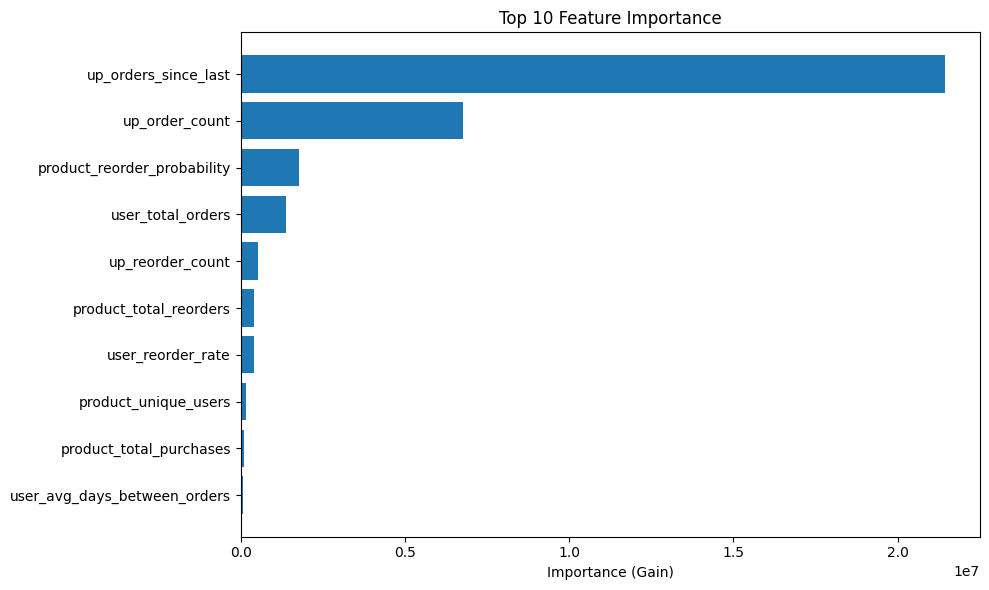


✓ Feature importance calculated


In [7]:
# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'].head(10), importance_df['importance'].head(10))
plt.xlabel('Importance (Gain)')
plt.title('Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n✓ Feature importance calculated")

In [8]:
# Prepare test data
X_test = test_data[feature_cols]

print(f"Test data shape: {X_test.shape}")
print("Generating predictions...")

# Predict probabilities
test_predictions = model.predict(X_test, num_iteration=model.best_iteration)

print(f"✓ Predictions generated: {len(test_predictions):,}")
print(f"Prediction range: [{test_predictions.min():.4f}, {test_predictions.max():.4f}]")
print(f"Mean prediction: {test_predictions.mean():.4f}")

Test data shape: (4833292, 14)
Generating predictions...
✓ Predictions generated: 4,833,292
Prediction range: [0.0239, 0.9522]
Mean prediction: 0.3701


In [9]:
# Add predictions to test data
test_data['reorder_probability'] = test_predictions

# Save full predictions
test_data[['user_id', 'product_id', 'reorder_probability']].to_csv(
    '../data/processed/test_predictions.csv', 
    index=False
)

print("✓ Predictions saved to: ../data/processed/test_predictions.csv")
print(f"\nSample predictions:")
print(test_data[['user_id', 'product_id', 'reorder_probability']].head(10))

# Summary statistics
print(f"\nPrediction Summary:")
print(f"Total predictions: {len(test_predictions):,}")
print(f"Predictions >= 0.7 (high confidence): {(test_predictions >= 0.7).sum():,} ({(test_predictions >= 0.7).mean()*100:.2f}%)")
print(f"Predictions >= 0.5: {(test_predictions >= 0.5).sum():,} ({(test_predictions >= 0.5).mean()*100:.2f}%)")
print(f"Predictions >= 0.3: {(test_predictions >= 0.3).sum():,} ({(test_predictions >= 0.3).mean()*100:.2f}%)")

✓ Predictions saved to: ../data/processed/test_predictions.csv

Sample predictions:
   user_id  product_id  reorder_probability
0    45082       17330             0.226270
1    45082       27407             0.185191
2    45082       35419             0.222327
3    45082         196             0.307405
4    45082       44635             0.184777
5    45082       26878             0.212158
6    45082       25783             0.228972
7    45082       41290             0.278422
8    45082       33198             0.325426
9    45082       23020             0.226368

Prediction Summary:
Total predictions: 4,833,292
Predictions >= 0.7 (high confidence): 668,589 (13.83%)
Predictions >= 0.5: 1,449,282 (29.99%)
Predictions >= 0.3: 2,521,736 (52.17%)


In [10]:
import joblib

# Save model
model_path = '../models/lgbm_reorder_model.txt'
model.save_model(model_path)

print(f"✓ Model saved to: {model_path}")

# Also save feature importance for reference
importance_df.to_csv('../models/feature_importance.csv', index=False)
print("✓ Feature importance saved to: ../models/feature_importance.csv")

print("\n" + "="*60)
print("MODEL TRAINING COMPLETE")
print("="*60)
print(f"Final Validation AUC: {roc_auc_score(y_val, y_pred_proba):.4f}")
print(f"Best F1 Score: {f1_scores[optimal_idx]:.4f} (threshold={optimal_threshold:.4f})")
print(f"Test predictions generated: {len(test_predictions):,}")
print("="*60)

✓ Model saved to: ../models/lgbm_reorder_model.txt
✓ Feature importance saved to: ../models/feature_importance.csv

MODEL TRAINING COMPLETE
Final Validation AUC: 0.8291
Best F1 Score: 0.4312 (threshold=0.7127)
Test predictions generated: 4,833,292
